In [1]:
from google.colab import drive

drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd drive/MyDrive/Challenge - CybelAngel !
!ls

/content/drive/MyDrive/Challenge - CybelAngel !
 data.csv
 glove.42B.300d.txt
'Internship 2022 Data scientist - technical guidelines.pdf'
 models
 pizza_data.json
 pizza_notebook.ipynb


In [280]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import itertools
from tqdm import tqdm
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as tf_text

import keras
from keras.models import Model
import keras.backend as K
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig, CpmTokenizer

In [4]:
data = pd.read_json("pizza_data.json")
data.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

# Preliminary data visualization

Text(0.5, 1.0, 'nb of people who received and did not receive a pizza (4040 total)')

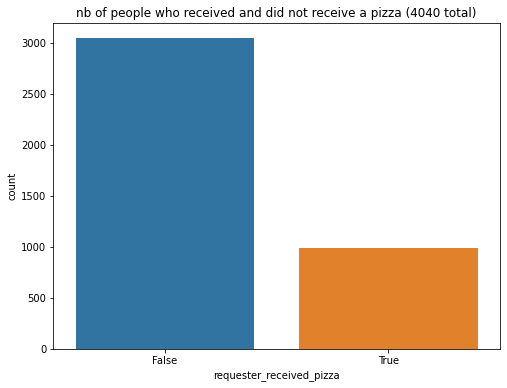

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x=data.loc[:, "requester_received_pizza"])
ax.set_title(
    f"nb of people who received and did not receive a pizza ({data.shape[0]} total)"
)

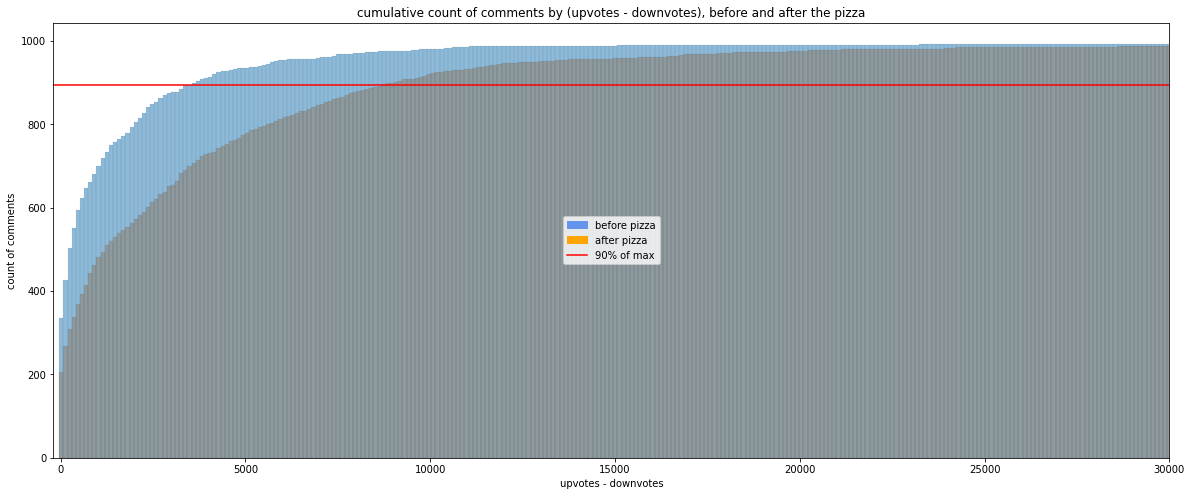

In [6]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.histplot(
    data.loc[
        data.requester_received_pizza == True,
        [
            "requester_upvotes_minus_downvotes_at_request",
            "requester_upvotes_minus_downvotes_at_retrieval",
        ],
    ],
    stat="count",
    cumulative=True,
    kde=False,
    bins=2_000,
    ax=ax,
    legend=False,
)
ax.axhline(y=0.90 * 994, xmin=0, xmax=1, color="r", label="90% of max")
ax.set_xlim([-200, 30_000])
ax.set_xlabel("upvotes - downvotes")
ax.set_ylabel("count of comments")
ax.set_title(
    "cumulative count of comments by (upvotes - downvotes), before and after the pizza"
)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

before_patch = Patch(color="cornflowerblue", label="before pizza")
after_patch = Patch(color="orange", label="after pizza")
x_line = Line2D([0], [0], color="red", label="90% of max")

ax.legend(handles=[before_patch, after_patch, x_line], loc="center")

# Data preprocessing

## Avoiding a post-hoc bias

#### List of quantitative features :

In [7]:
quant_cols = data._get_numeric_data().columns
print(quant_cols)

Index(['number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_number_of_comments_at_retrieval',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'requester_received_pizza',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_minus_do

Some of these features were taken at the retrieval. This creates a bias, because people are more likely to upvote a comment from a person who was gifted a free pizza. Also, the purpose of this study is to be able to predict who is going to win the pizza, so this makes no sense to use data after the pizza was gifted (or not).

In [8]:
for col in quant_cols:
    if "retrieval" in col:
        data.drop(col, axis=1, inplace=True)
data.drop("post_was_edited", axis=1, inplace=True)

#### Visualizing edits

In [9]:
for i, text in enumerate(
    data.loc[data.request_text != data.request_text_edit_aware, "request_text"].values[
        :4
    ]
):
    print(f"\n{100*'*'} \nTEXT {i}) \n\n{text}")


**************************************************************************************************** 
TEXT 0) 

Austin, Texas

My two roommates and I are hungry as hell. We were all sort of counting on the deposit from our last apartment to help us out, but they claimed there was damages, so we did not receive anything. So, we're sort of struggling. Is anyone able to help us out for dinner tonight? We'd really appreciate it!

EDIT: Received a Dominos gift card from jetboyterp! THANK YOU!

**************************************************************************************************** 
TEXT 1) 

I'm a college grad living in NYC. Interning to keep my feet in the business, freelancing and dog walking when I'm not interning. The money I made this month is just enough to keep a roof over my head and my heat kept on.  I have no food, having eaten down what's left of my pantry over the course of the month. I've had nothing to eat but condiments for the last two days. I woke up this morni

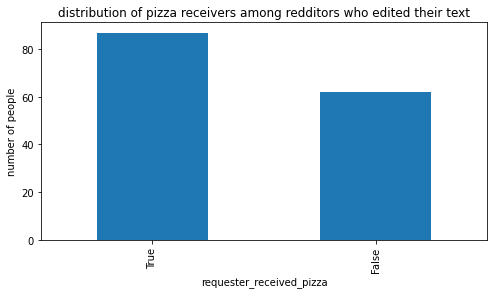

In [10]:
data.loc[
    data.request_text != data.request_text_edit_aware,
    ["request_text", "request_text_edit_aware", "requester_received_pizza"],
]["requester_received_pizza"].value_counts().plot(
    kind="bar",
    xlabel="requester_received_pizza",
    ylabel="number of people",
    title="distribution of pizza receivers among redditors who edited their text",
    figsize=(8, 4),
)

Most of the time, when an edit is made, the requester received a pizza (58.4%). After taking a quick glance over the edits, these are generally made AFTER they received a pizza, to thank the giver. Thus, it would create a bias to use the request text without removing the edit. We will only keep $\textit{request_text_edit_aware}$

In [11]:
data.drop("request_text", axis=1, inplace=True)

#### Followed subreddits influence

In [12]:
subs_piz = pd.DataFrame(
    [
        item
        for sublist in data.loc[
            data.requester_received_pizza == True, "requester_subreddits_at_request"
        ].values
        for item in sublist
    ]
).value_counts(normalize=True)

subs_npiz = pd.DataFrame(
    [
        item
        for sublist in data.loc[
            data.requester_received_pizza == False,
            "requester_subreddits_at_request",
        ].values
        for item in sublist
    ]
).value_counts(normalize=True)

In [13]:
print(
    "avg nb of subs of pizza receivers :",
    np.round(
        data.loc[
            data.requester_received_pizza == True,
            "requester_number_of_subreddits_at_request",
        ].mean(),
        2,
    ),
)
print(
    "avg nb of subs of non pizza receivers :",
    np.round(
        data.loc[
            data.requester_received_pizza == False,
            "requester_number_of_subreddits_at_request",
        ].mean(),
        2,
    ),
)

avg nb of subs of pizza receivers : 19.51
avg nb of subs of non pizza receivers : 17.61


In [14]:
set(subs_piz[:20].index) == set(subs_npiz[:20].index)

True

The top-20 most followed subreddits by pizza receivers and non-pizza receivers are the same.

In [15]:
data.drop("requester_subreddits_at_request", axis=1, inplace=True)

Let's see the number of subreddits influence.

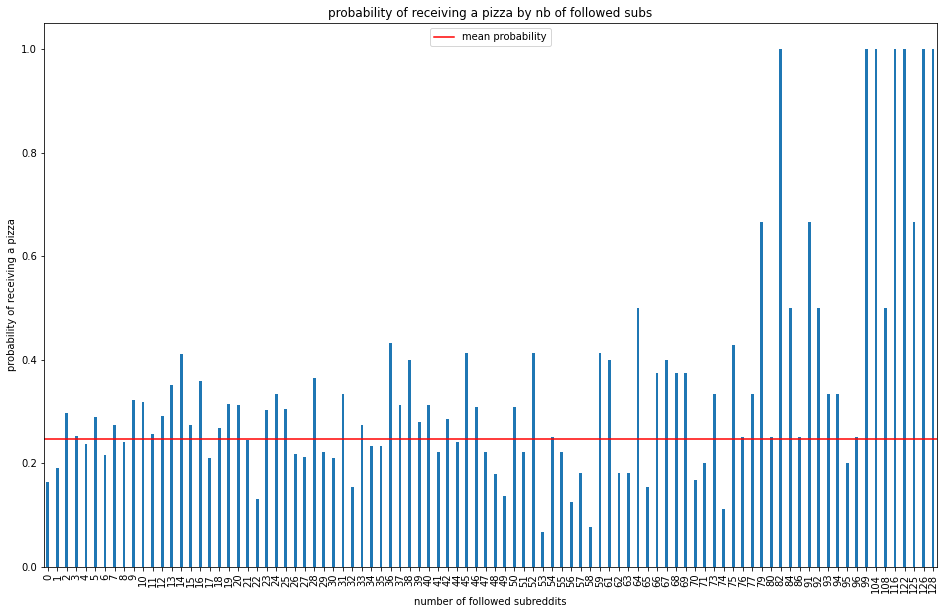

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))
(
    data.loc[
        data["requester_received_pizza"] == True,
        "requester_number_of_subreddits_at_request",
    ].value_counts()
    / data.loc[
        :,
        "requester_number_of_subreddits_at_request",
    ].value_counts()
).dropna().plot(kind="bar", width=0.3, ax=ax, label="")

ax.axhline(y=994 / 4040, xmin=0, xmax=1, color="r", label="mean probability")
ax.set_title("probability of receiving a pizza by nb of followed subs")
ax.set_xlabel("number of followed subreddits")
ax.set_ylabel("probability of receiving a pizza")
ax.legend(loc="upper center")

## Quantitative features processing

In [17]:
quant_cols = data._get_numeric_data().columns
print(quant_cols)

Index(['requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request', 'requester_received_pizza',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')


### Correlation matrix

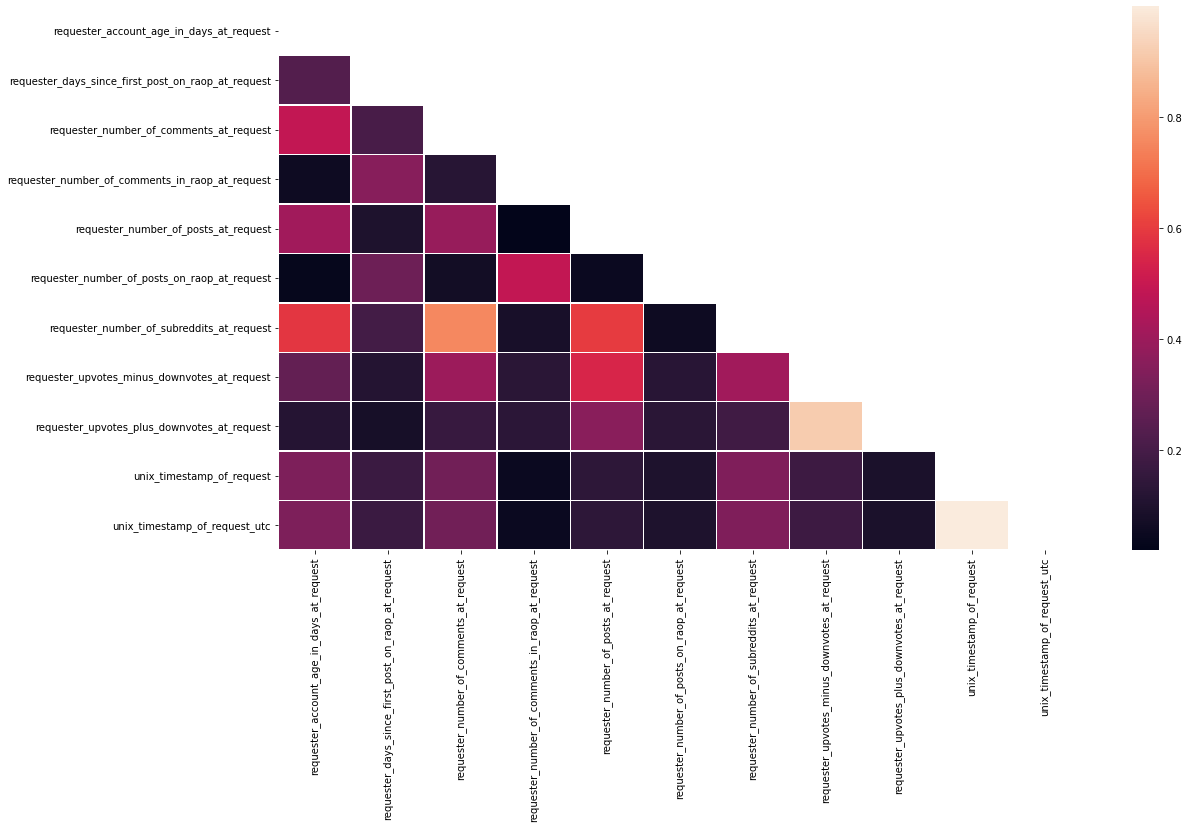

In [18]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(
    data[quant_cols].drop("requester_received_pizza", axis=1).corr(),
    mask=np.triu(np.ones_like(data.drop("requester_received_pizza", axis=1).corr())),
    annot=False,
    linewidths=0.5,
    ax=ax,
)

### PCA

In [19]:
X = StandardScaler().fit_transform(
    data[quant_cols].drop("requester_received_pizza", axis=1)
)

n = data[quant_cols].shape[1] - 1
pca = PCA(n_components=n)

PCs = [f"PC{i}" for i in range(1, n + 1)]

components = pca.fit_transform(X)
pc_df = pd.DataFrame(data=components, columns=PCs)
pc_df["requester_received_pizza"] = data["requester_received_pizza"]

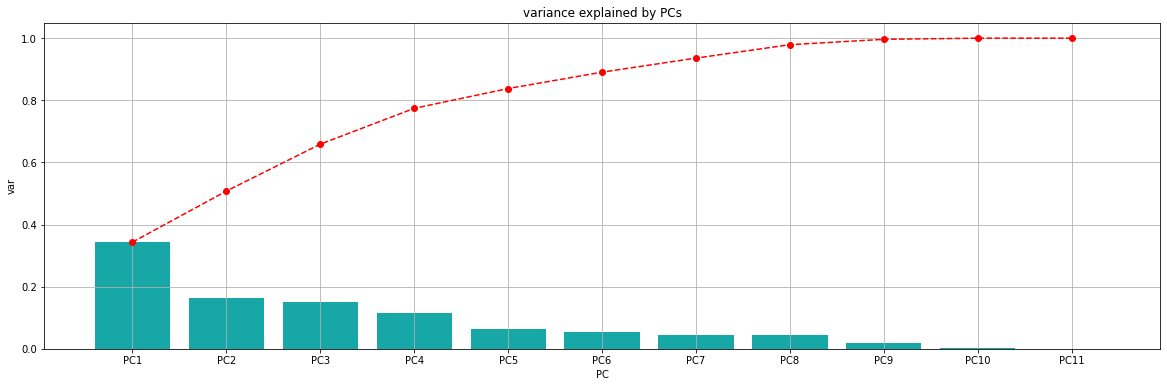

In [20]:
var = pca.explained_variance_ratio_
var_df = pd.DataFrame({"var": var, "cum var": None, "PC": PCs})
cum_var = np.cumsum(var)

var_df["cum var"] = cum_var

plt.figure(figsize=(20, 6))
sns.barplot(data=var_df, x="PC", y="var", color="c")
plt.plot(var_df["PC"], var_df["cum var"], "r--o")
plt.grid()
plt.title("variance explained by PCs");

### Principal components correlation with target variable

In [21]:
target_corr = (
    pc_df.corr()
    .loc[
        "requester_received_pizza",
        pc_df.corr().columns != "requester_received_pizza",
    ]
    .apply(lambda x: np.round(abs(x), 2))
    .sort_values(ascending=False)
)
display(target_corr)

PC3     0.14
PC4     0.12
PC2     0.10
PC8     0.04
PC1     0.03
PC7     0.02
PC9     0.02
PC10    0.02
PC11    0.02
PC5     0.01
PC6     0.01
Name: requester_received_pizza, dtype: float64

Text(0.5, 1.0, 'absolute correlation between target and PCs\n(heatmap)')

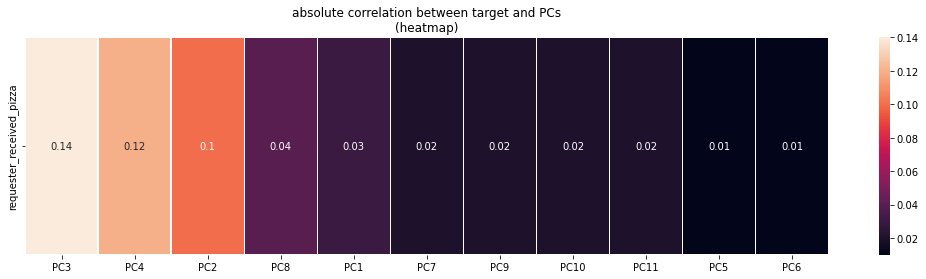

In [22]:
fig, ax = plt.subplots(figsize=(18, 4))
sns.heatmap(
    [target_corr],
    annot=True,
    linewidths=0.5,
    ax=ax,
)
ax.set_xticklabels(target_corr.index)
ax.set_yticklabels(["requester_received_pizza"])
ax.set_title("absolute correlation between target and PCs\n(heatmap)")

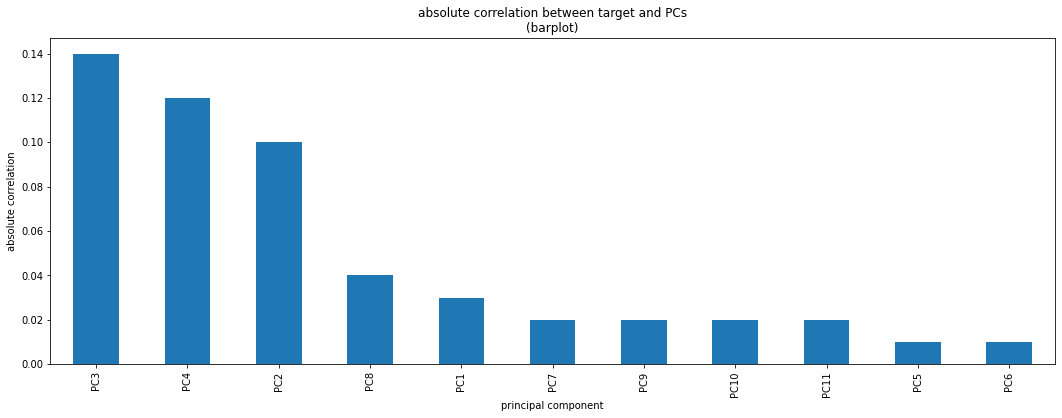

In [23]:
target_corr.plot(
    kind="bar",
    figsize=(18, 6),
    xlabel="principal component",
    ylabel="absolute correlation",
    title="absolute correlation between target and PCs\n(barplot)",
)

### t-SNE visualization

In [24]:
tsne = TSNE(n_components=2, perplexity=30.0, learning_rate="auto", init="pca")
tsne_result = tsne.fit_transform(pc_df.loc[:, ["PC3", "PC4", "PC2"]])
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


Text(0.5, 1.0, '2D t-SNE visualization of users in the (PC3, PC4, PC2) basis')

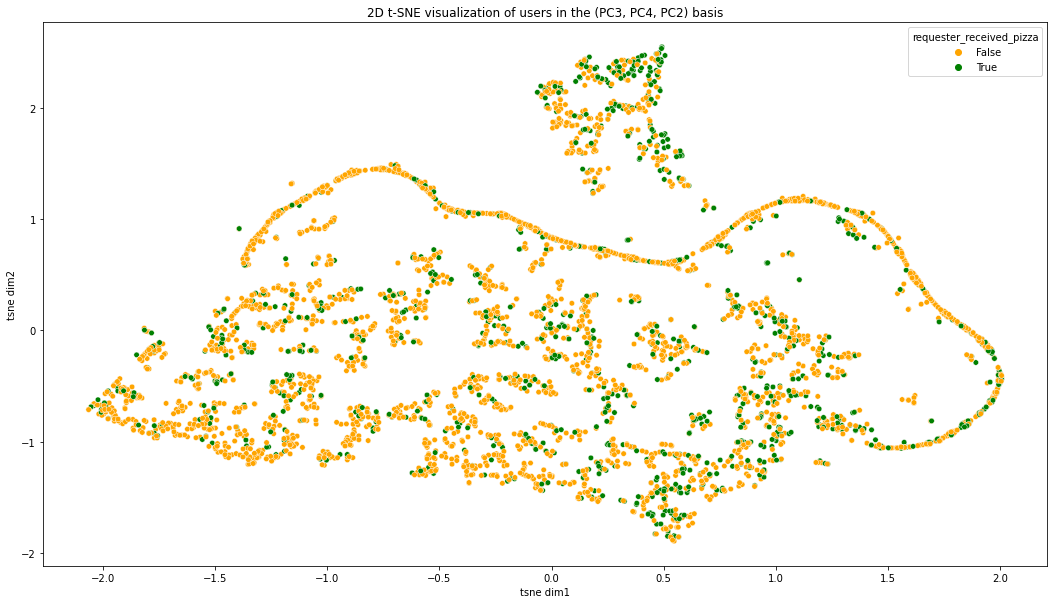

In [25]:
fig, ax = plt.subplots(figsize=(18, 10))

sns.scatterplot(
    x=tsne_result_scaled[:, 0],
    y=tsne_result_scaled[:, 1],
    hue=data["requester_received_pizza"],
    palette={False: "orange", True: "green"},
    s=30,
)

ax.set_xlabel("tsne dim1")
ax.set_ylabel("tsne dim2")
ax.set_title("2D t-SNE visualization of users in the (PC3, PC4, PC2) basis")

In [26]:
data = pd.concat(
    [
        data.drop(quant_cols, axis=1),
        pc_df.loc[:, ["PC3", "PC4", "PC2", "requester_received_pizza"]],
    ],
    axis=1,
).drop(
    [
        "giver_username_if_known",
        "request_id",
        "requester_user_flair",
        "requester_username",
    ],
    axis=1,
)

In [27]:
data["requester_received_pizza"] = data["requester_received_pizza"].astype(int)

In [28]:
data.columns = ["text", "title", "PC3", "PC4", "PC2", "pizza"]
data.to_csv("data.csv", index=False)

# Classification models

In [29]:
data = pd.read_csv("data.csv")

In [30]:
from sklearn.utils import resample

data_majority = data[data.pizza == 0]
data_minority = data[data.pizza == 1]

data_majority_downsampled = resample(data_majority, replace=False, n_samples=1500)

data_downsampled = pd.concat([data_majority_downsampled, data_minority])

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_downsampled.drop("pizza", axis=1),
    data_downsampled["pizza"],
    test_size=0.25,
    stratify=data_downsampled["pizza"],
)

## MLP : PCA components

In [32]:
data[["PC3", "PC4", "PC2", "pizza"]]

,PC3,PC4,PC2,pizza
0,0.046787,-0.116234,0.880279,0.0
1,-0.296689,-0.361854,0.126620,0.0
2,0.049266,-0.057330,0.803627,0.0
3,-0.005805,-0.078688,0.666647,0.0
4,0.795062,0.850671,-1.413731,0.0
...,...,...,...,...
4036,0.122937,1.693220,-1.474360,0.0
4037,4.240604,-1.153677,-2.308401,1.0
4038,-0.321514,0.867012,-1.243811,0.0
4039,0.056013,0.278513,0.346688,0.0


In [33]:
model_pc = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(3,)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

In [34]:
model_pc.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_pc.fit(
    X_train[["PC3", "PC4", "PC2"]], y_train, epochs=100, batch_size=32, verbose=0
)

In [35]:
test_loss, test_acc = model_pc.evaluate(X_test[["PC3", "PC4", "PC2"]], y_test)
print("Test accuracy:", test_acc)

20/20 [==============================] - 0s 2ms/step - loss: 0.6326 - accuracy: 0.6603
Test accuracy: 0.6602563858032227


In [36]:
pc_pred = model_pc.predict(X_test[["PC3", "PC4", "PC2"]])

AUC score : 0.6534725568942437
best threshold 0.3704, G-Mean = 0.6237
FPR = 0.395, TPR = 0.643


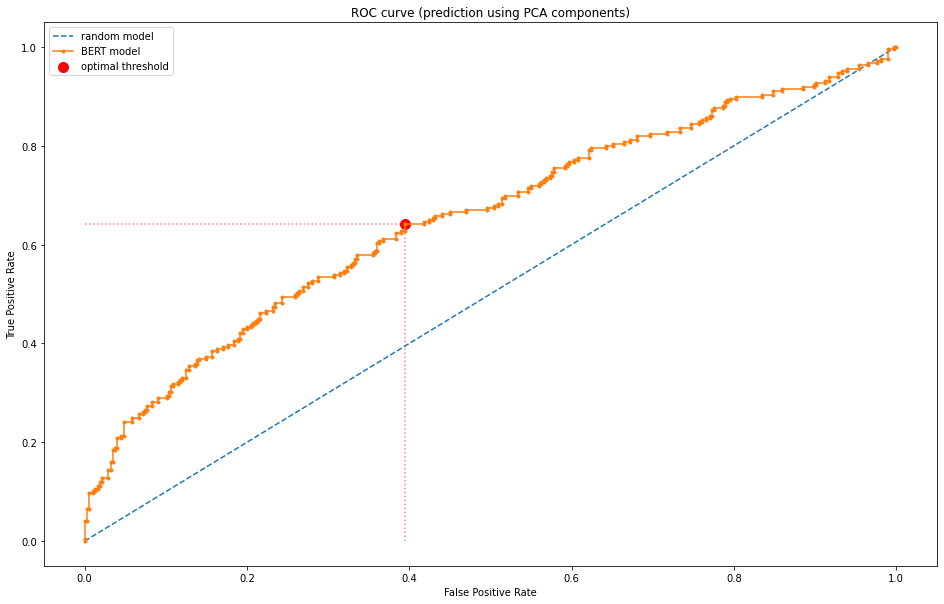

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, pc_pred)
auc = roc_auc_score(y_test, pc_pred)
print(f"AUC score : {auc}")

gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)

print(f"best threshold {thresholds[ix]:.4f}, G-Mean = {gmeans[ix]:.4f}")
print(f"FPR = {fpr[ix]:.3f}, TPR = {tpr[ix]:.3f}")

plt.figure(figsize=(16, 10))
plt.plot([0, 1], [0, 1], linestyle="--", label="random model")
plt.plot(fpr, tpr, marker=".", label="MLP on PCA model")
plt.title("ROC curve (prediction using PCA components)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.scatter(x=fpr[ix], y=tpr[ix], color="r", s=100, alpha=1, label="optimal threshold")
plt.hlines(y=tpr[ix], xmin=0, xmax=fpr[ix], color="r", linestyle=":", alpha=0.5)
plt.vlines(x=fpr[ix], ymin=0, ymax=tpr[ix], color="r", linestyle=":", alpha=0.5)
plt.legend()
plt.show()

Text(0.5, 1.0, 'g-mean = sqrt(tpr(1-fpr)) by threshold')

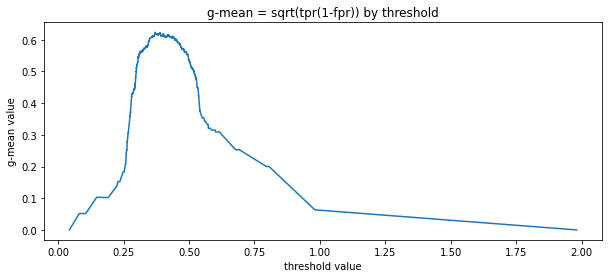

In [40]:
plt.figure(figsize=(10, 4))
plt.plot(thresholds, gmeans)
plt.xlabel("threshold value")
plt.ylabel("g-mean value")
plt.title("g-mean = sqrt(tpr(1-fpr)) by threshold")

Text(0.5, 1.0, 'performance on test data using the PCA model\nthreshold=0.3704 (G-mean maximization)')

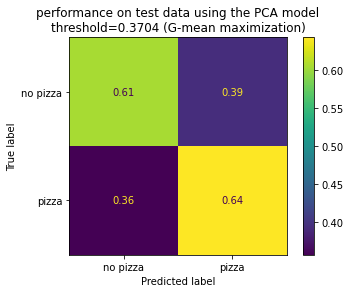

In [41]:
pred_binary = pc_pred.copy()

threshold = thresholds[ix]
pred_binary[pred_binary >= threshold] = 1
pred_binary[pred_binary < threshold] = 0

cm = confusion_matrix(y_test, pred_binary, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no pizza", "pizza"])
disp.plot()

plt.title(
    f"performance on test data using the PCA model\nthreshold={thresholds[ix]:.4f} (G-mean maximization)"
)

In [42]:
f1 = f1_score(y_test, pred_binary)

print("F1 score", f1)
print("Classification Report")
print(classification_report(y_test, pred_binary, target_names=["pizza", "no_pizza"]))

F1 score 0.5745062836624775
Classification Report
              precision    recall  f1-score   support

       pizza       0.72      0.61      0.66       375
    no_pizza       0.52      0.64      0.57       249

    accuracy                           0.62       624
   macro avg       0.62      0.62      0.62       624
weighted avg       0.64      0.62      0.62       624



## BERT

### Preprocessing

In [44]:
def unicode_to_ascii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn"
    )


def clean_stopwords_shortwords(w):
    stopwords_list = stopwords.words("english")
    words = w.split()
    clean_words = [
        word for word in words if (word not in stopwords_list) and len(word) > 2
    ]
    return " ".join(clean_words)


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = clean_stopwords_shortwords(w)
    w = re.sub(r"@\w+", "", w)
    return w

In [45]:
data = pd.read_csv("data.csv", encoding="ISO-8859-1")

In [46]:
print("text\n", data.loc[0, "text"])
print("\ntitle\n", data.loc[0, "title"])

text
 Hi I am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated

title
 Request Colorado Springs Help Us Please


In [47]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
data["text"] = data["text"].astype(str).map(preprocess_sentence)
data["title"] = data["title"].astype(str).map(preprocess_sentence)

In [49]:
print("text\n", data.loc[0, "text"])
print("\ntitle\n", data.loc[0, "title"])

text
 need food children military family really hit hard times exahusted means help able feed family make another night ask know blessing coming whatever find heart give greatly appreciated

title
 request colorado springs help please


In [50]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc7043

In [51]:
print("text\n", bert_tokenizer.tokenize(data.loc[0, "text"]))
print("\ntitle\n", bert_tokenizer.tokenize(data.loc[0, "title"]))

text
 ['need', 'food', 'children', 'military', 'family', 'really', 'hit', 'hard', 'times', 'ex', '##ahu', '##sted', 'means', 'help', 'able', 'feed', 'family', 'make', 'another', 'night', 'ask', 'know', 'blessing', 'coming', 'whatever', 'find', 'heart', 'give', 'greatly', 'appreciated']

title
 ['request', 'colorado', 'springs', 'help', 'please']


What is the length of the texts ?

In [52]:
data["text"].apply(lambda x: len(str(x).split())).describe()

count    4041.000000
mean       36.194506
std        31.855946
min         0.000000
25%        17.000000
50%        28.000000
75%        45.000000
max       391.000000
Name: text, dtype: float64

We'll pick max_length=64.

In [53]:
txt = data.loc[0, "text"]

tokenized_sequence = bert_tokenizer.encode_plus(
    txt,
    add_special_tokens=True,
    max_length=64,
    pad_to_max_length=True,
    return_attention_mask=True,
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [54]:
[print(key, ":", value) for key, value in tokenized_sequence.items()]

input_ids : [101, 2342, 2833, 2336, 2510, 2155, 2428, 2718, 2524, 2335, 4654, 21463, 14701, 2965, 2393, 2583, 5438, 2155, 2191, 2178, 2305, 3198, 2113, 13301, 2746, 3649, 2424, 2540, 2507, 6551, 12315, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
token_type_ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[None, None, None]

In [55]:
bert_tokenizer.decode(tokenized_sequence["input_ids"])

'[CLS] need food children military family really hit hard times exahusted means help able feed family make another night ask know blessing coming whatever find heart give greatly appreciated [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [56]:
data_majority = data[data.pizza == 0]
data_minority = data[data.pizza == 1]

data_majority_downsampled = resample(
    data_majority, replace=False, n_samples=1500, random_state=0
)

data_downsampled = pd.concat([data_majority_downsampled, data_minority])

In [57]:
texts = data_downsampled["text"]
labels = data_downsampled["pizza"]
len(texts), len(labels)

(2494, 2494)

In [58]:
input_ids = []
attention_masks = []

for text in texts:
    bert_inp = bert_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        pad_to_max_length=True,
        return_attention_mask=True,
    )
    input_ids.append(bert_inp["input_ids"])
    attention_masks.append(bert_inp["attention_mask"])

input_ids = np.asarray(input_ids)
attention_masks = np.array(attention_masks)
labels = np.array(labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [59]:
print("downsampled dataset (994 pizza, 1500 no pizza)")
len(input_ids), len(attention_masks), len(labels)

downsampled dataset (994 pizza, 1500 no pizza)


(2494, 2494, 2494)

In [60]:
train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(
    input_ids, labels, attention_masks, test_size=0.2, stratify=labels, random_state=0
)

print(f"train_inp.shape = {train_inp.shape}\nval_inp.shape = {val_inp.shape}")
print(f"\ntrain_label.shape = {train_label.shape}\nval_label.shape = {val_label.shape}")
print(f"\ntrain_mask.shape= {train_mask.shape}\nval_mask.shape = {val_mask.shape}")

train_inp.shape = (1995, 256)
val_inp.shape = (499, 256)

train_label.shape = (1995,)
val_label.shape = (499,)

train_mask.shape= (1995, 256)
val_mask.shape = (499, 256)


### TFBertModel

In [61]:
bert = TFBertModel.from_pretrained("bert-base-uncased")

input_ids = tf.keras.layers.Input(shape=(256,), name="input_ids", dtype="int32")
mask = tf.keras.layers.Input(shape=(256,), name="attention_mask", dtype="int32")
embeddings = bert(input_ids, attention_mask=mask)[1]
# X = tf.keras.layers.Dropout(0.1)(embeddings)
X = tf.keras.layers.Dense(128, activation="relu")(X)
y = tf.keras.layers.Dense(1, activation="sigmoid", name="outputs")(X)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 from cache at /ro

In [62]:
adam = tf.keras.optimizers.Adam(learning_rate=2e-5)
auc = tf.keras.metrics.AUC(name="auc")

check = tf.keras.callbacks.ModelCheckpoint(
    "models/bert_model.h5", monitor="val_auc", save_best_only=True, mode="max"
)

bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
bert_model.compile(
    optimizer=adam,
    loss="binary_crossentropy",
    metrics=["accuracy", auc],
)

In [63]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [64]:
bert_model.layers[2].trainable = True

In [65]:
history = bert_model.fit(
    [train_inp, train_mask],
    train_label,
    batch_size=32,
    epochs=7,
    validation_data=([val_inp, val_mask], val_label),
    callbacks=[check],
    verbose=1,
)

Epoch 1/7
63/63 [==============================] - 134s 2s/step - loss: 0.6848 - accuracy: 0.5855 - auc: 0.5349 - val_loss: 0.6677 - val_accuracy: 0.6092 - val_auc: 0.5915
Epoch 2/7
63/63 [==============================] - 116s 2s/step - loss: 0.6743 - accuracy: 0.5830 - auc: 0.5615 - val_loss: 0.6585 - val_accuracy: 0.6293 - val_auc: 0.6011
Epoch 3/7
63/63 [==============================] - 118s 2s/step - loss: 0.6537 - accuracy: 0.6165 - auc: 0.6159 - val_loss: 0.6949 - val_accuracy: 0.5311 - val_auc: 0.6016
Epoch 4/7
63/63 [==============================] - 106s 2s/step - loss: 0.6144 - accuracy: 0.6446 - auc: 0.6967 - val_loss: 0.7300 - val_accuracy: 0.5952 - val_auc: 0.5619
Epoch 5/7
63/63 [==============================] - 107s 2s/step - loss: 0.5306 - accuracy: 0.7469 - auc: 0.8015 - val_loss: 0.6969 - val_accuracy: 0.5932 - val_auc: 0.5652
Epoch 6/7
63/63 [==============================] - 107s 2s/step - loss: 0.3503 - accuracy: 0.8511 - auc: 0.9218 - val_loss: 1.0507 - val_acc

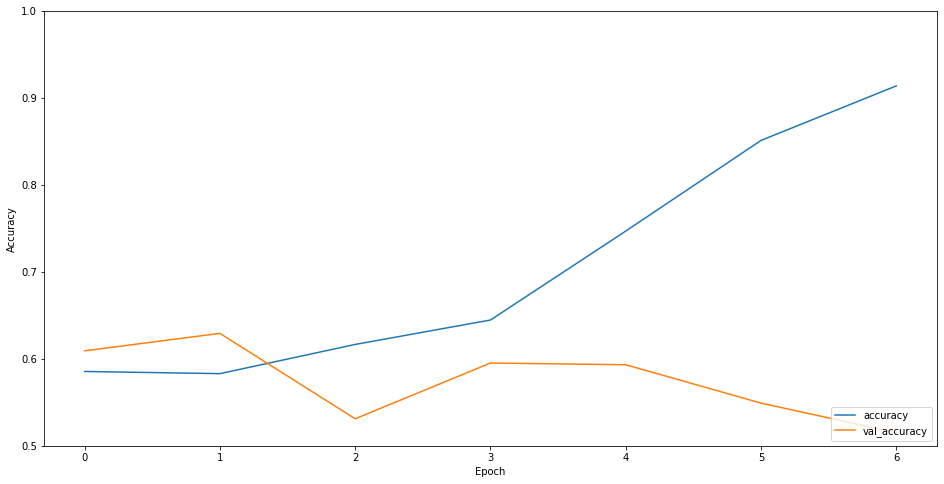

In [66]:
plt.figure(figsize=(16, 8))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

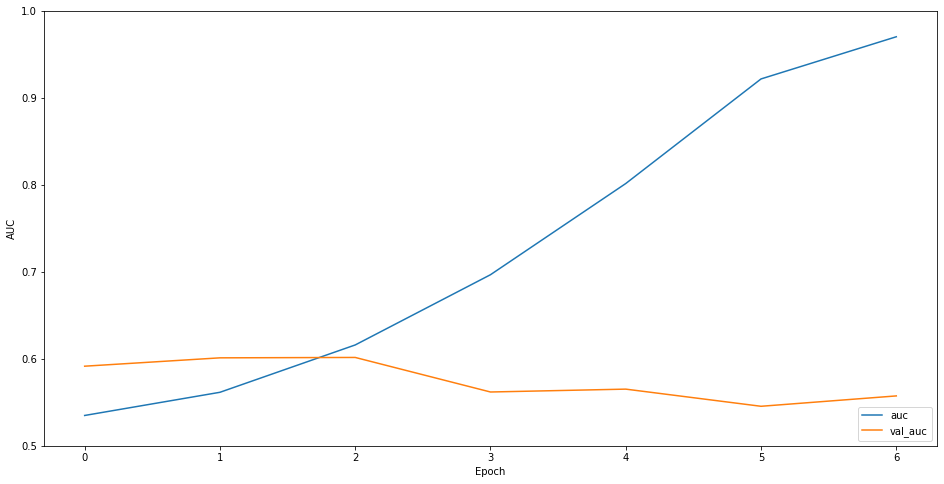

In [67]:
plt.figure(figsize=(16, 8))
plt.plot(history.history["auc"], label="auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

In [70]:
trained_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

trained_model.compile(
    optimizer=adam,
    loss="binary_crossentropy",
    metrics=["accuracy", auc],
)

trained_model.load_weights("./models/bert_model.h5")

### Model evaluation

In [71]:
preds = trained_model.predict([val_inp, val_mask], batch_size=32)

AUC score : 0.6020519262981575
best threshold 0.5731, G-Mean = 0.5952
FPR = 0.353, TPR = 0.548


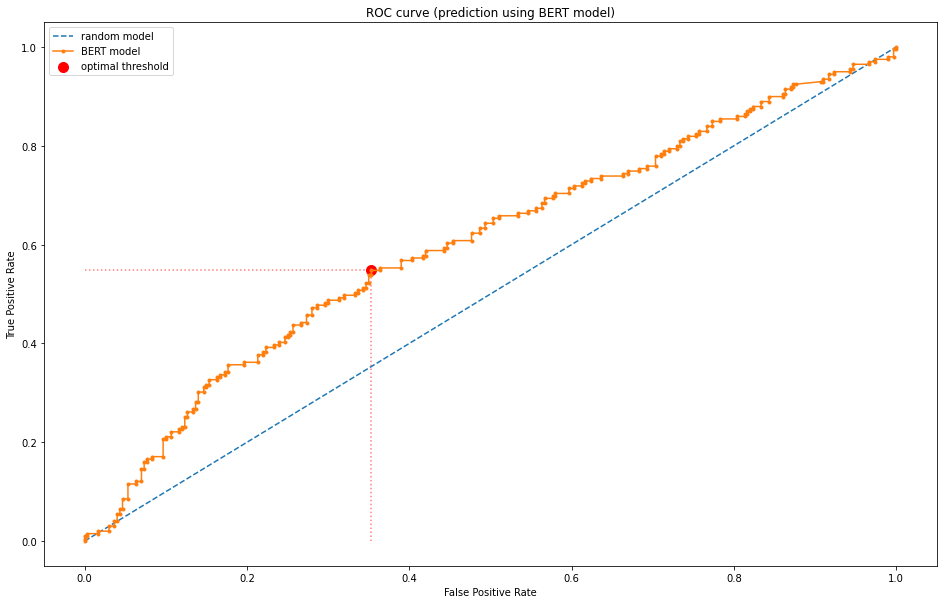

In [72]:
fpr, tpr, thresholds = roc_curve(val_label, preds)
auc = roc_auc_score(val_label, preds)
print(f"AUC score : {auc}")

gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)

print(f"best threshold {thresholds[ix]:.4f}, G-Mean = {gmeans[ix]:.4f}")
print(f"FPR = {fpr[ix]:.3f}, TPR = {tpr[ix]:.3f}")

plt.figure(figsize=(16, 10))
plt.plot([0, 1], [0, 1], linestyle="--", label="random model")
plt.plot(fpr, tpr, marker=".", label="BERT model")
plt.title("ROC curve (prediction using BERT model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.scatter(x=fpr[ix], y=tpr[ix], color="r", s=100, alpha=1, label="optimal threshold")
plt.hlines(y=tpr[ix], xmin=0, xmax=fpr[ix], color="r", linestyle=":", alpha=0.5)
plt.vlines(x=fpr[ix], ymin=0, ymax=tpr[ix], color="r", linestyle=":", alpha=0.5)
plt.legend()
plt.show()

Text(0.5, 1.0, 'g-mean = tpr(1-fpr) by threshold')

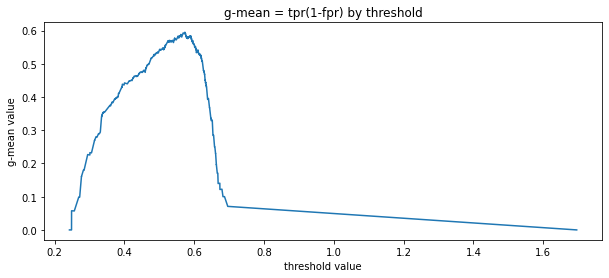

In [73]:
plt.figure(figsize=(10, 4))
plt.plot(thresholds, gmeans)
plt.xlabel("threshold value")
plt.ylabel("g-mean value")
plt.title("g-mean = tpr(1-fpr) by threshold")

Text(0.5, 1.0, 'performance on test data using the BERT model\nthreshold=0.5731 (G-mean maximization)')

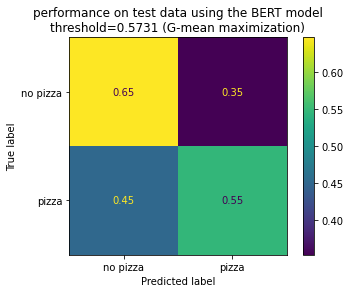

In [74]:
pred_binary = preds.copy()

threshold = thresholds[ix]

pred_binary[pred_binary >= threshold] = 1
pred_binary[pred_binary < threshold] = 0

cm = confusion_matrix(val_label, pred_binary, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no pizza", "pizza"])
disp.plot()

plt.title(
    f"performance on test data using the BERT model\nthreshold={thresholds[ix]:.4f} (G-mean maximization)"
)

In [75]:
f1 = f1_score(val_label, pred_binary)

print("F1 score", f1)
print("Classification Report")
print(classification_report(val_label, pred_binary, target_names=["pizza", "no_pizza"]))

F1 score 0.5265700483091789
Classification Report
              precision    recall  f1-score   support

       pizza       0.68      0.65      0.66       300
    no_pizza       0.51      0.55      0.53       199

    accuracy                           0.61       499
   macro avg       0.60      0.60      0.60       499
weighted avg       0.61      0.61      0.61       499



Text(0.5, 1.0, 'performance on test data using the BERT model\nthreshold=0.501')

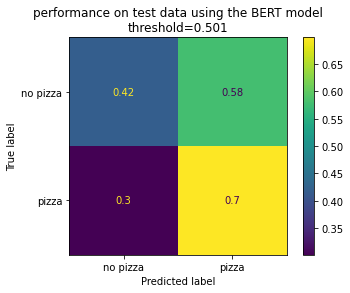

In [89]:
pred_binary = preds.copy()

threshold = 0.501

pred_binary[pred_binary >= threshold] = 1
pred_binary[pred_binary < threshold] = 0

cm = confusion_matrix(val_label, pred_binary, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no pizza", "pizza"])
disp.plot()

plt.title("performance on test data using the BERT model\nthreshold=0.501")

In [90]:
f1 = f1_score(val_label, pred_binary)

print("F1 score", f1)
print("Classification Report")
print(classification_report(val_label, pred_binary, target_names=["pizza", "no_pizza"]))

F1 score 0.54296875
Classification Report
              precision    recall  f1-score   support

       pizza       0.68      0.42      0.52       300
    no_pizza       0.44      0.70      0.54       199

    accuracy                           0.53       499
   macro avg       0.56      0.56      0.53       499
weighted avg       0.58      0.53      0.53       499



## XGBoost (Glove embedding)

In [91]:
import os
import glob
import spacy
import string
import re
import nltk
from spacy.symbols import ORTH
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer

In [111]:
data = pd.read_csv("data.csv").drop(["PC3", "PC4", "PC2"], axis=1).dropna()
data

,text,title,pizza
0,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0
1,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",0.0
2,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.0
3,"It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",0.0
4,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,0.0
...,...,...,...
4036,Is anyone out there kind enough to help me out...,[REQUEST] Anyone help a recent college grad wh...,0.0
4037,If someone could hook me up with a $15 gift ca...,[Request][USA] Papa Johns is giving away one f...,1.0
4038,"Have today off, soo I'll be stuck in the house...","[REQUEST][MI,USA] Day off, would love pizza fo...",0.0
4039,"I've never done anything like this before, but...",[Request] Nashua Nh Mother of one hungry 2 yea...,0.0


### Glove Embedding

In [112]:
re_br = re.compile(r"<\s*br\s*/?>", re.IGNORECASE)


def sub_br(x):
    return re_br.sub("\n", x)


my_tok = spacy.load("en_core_web_sm")


def spacy_tok(x):
    return [tok.text for tok in my_tok.tokenizer(sub_br(x))]

In [113]:
stops = set(stopwords.words("english"))


def get_non_stopwords(review):
    """Returns a list of non-stopwords"""
    return {x: 1 for x in spacy_tok(str(review).lower()) if x not in stops}.keys()

In [114]:
def load_word_embeddings(file="glove.42B.300d.txt"):
    embeddings = {}
    with open(file, "r", encoding="utf8") as infile:
        for line in infile:
            values = line.split()
            embeddings[values[0]] = np.asarray(values[1:], dtype="float32")
    return embeddings

In [115]:
embeddings = load_word_embeddings()
len(embeddings.keys())

1917494

In [116]:
def sentence_features_v2(s, embeddings=embeddings, emb_size=300):
    # ignore stop words
    words = get_non_stopwords(s)
    words = [w for w in words if w.isalpha() and w in embeddings]
    if len(words) == 0:
        return np.hstack([np.zeros(emb_size)])
    M = np.array([embeddings[w] for w in words])
    return M.mean(axis=0)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(
    data["text"].apply(sentence_features_v2).values,
    data["pizza"],
    test_size=0.25,
    stratify=data["pizza"],
    random_state=0,
)

X_train = np.reshape(np.concatenate(X_train), (y_train.shape[0], 300))
X_test = np.reshape(np.concatenate(X_test), (y_test.shape[0], 300))

In [225]:
print(X_train.shape)
print(X_train[0].shape)

(2952, 300)
(300,)


### Fitting an XGBoost Classifier

In [226]:
xgb_pars = {
    "min_child_weight": 50,
    "eta": 0.02,
    "max_depth": 7,
    "subsample": 0.8,
    "silent": 1,
    "nthread": 4,
    "eval_metric": "logloss",
    "objective": "binary:logistic",
}

d_train = xgb.DMatrix(X_train, label=y_train)
d_val = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, "train"), (d_val, "valid")]

bst = xgb.train(
    xgb_pars,
    d_train,
    400,
    watchlist,
    early_stopping_rounds=50,
    verbose_eval=50,
)

[0]	train-logloss:0.687461	valid-logloss:0.688053
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.54664	valid-logloss:0.572174
[100]	train-logloss:0.505153	valid-logloss:0.551972
[150]	train-logloss:0.483334	valid-logloss:0.548249
[200]	train-logloss:0.465564	valid-logloss:0.547652
Stopping. Best iteration:
[167]	train-logloss:0.477024	valid-logloss:0.547361



In [227]:
preds = bst.predict(d_val)

AUC score : 0.6117190961453257
best threshold 0.2424, G-Mean = 0.6077
FPR = 0.430, TPR = 0.648


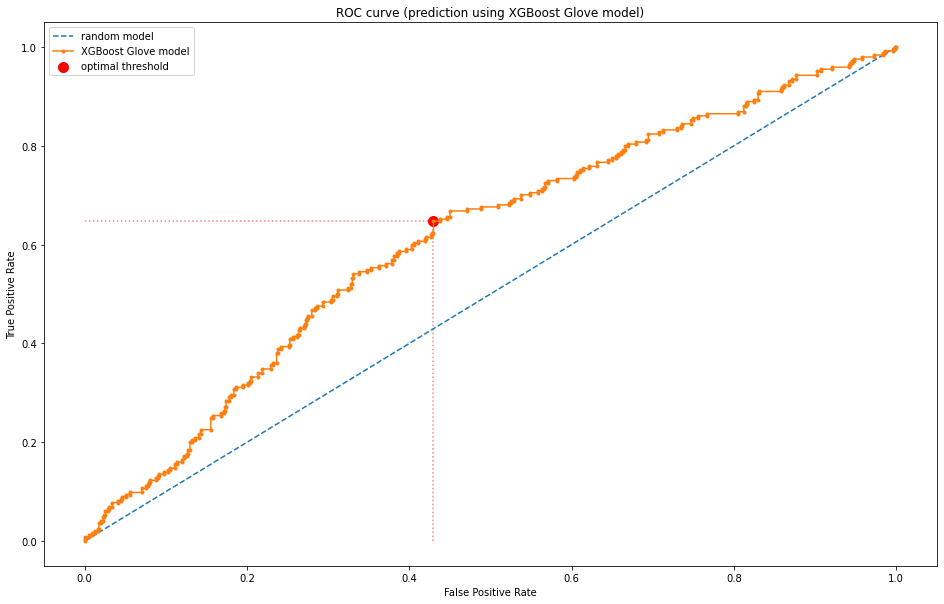

In [228]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
print(f"AUC score : {auc}")

gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)

print(f"best threshold {thresholds[ix]:.4f}, G-Mean = {gmeans[ix]:.4f}")
print(f"FPR = {fpr[ix]:.3f}, TPR = {tpr[ix]:.3f}")

plt.figure(figsize=(16, 10))
plt.plot([0, 1], [0, 1], linestyle="--", label="random model")
plt.plot(fpr, tpr, marker=".", label="XGBoost Glove model")
plt.title("ROC curve (prediction using XGBoost Glove model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.scatter(x=fpr[ix], y=tpr[ix], color="r", s=100, alpha=1, label="optimal threshold")
plt.hlines(y=tpr[ix], xmin=0, xmax=fpr[ix], color="r", linestyle=":", alpha=0.5)
plt.vlines(x=fpr[ix], ymin=0, ymax=tpr[ix], color="r", linestyle=":", alpha=0.5)
plt.legend()
plt.show()

Text(0.5, 1.0, 'g-mean = sqrt(tpr(1-fpr)) by threshold')

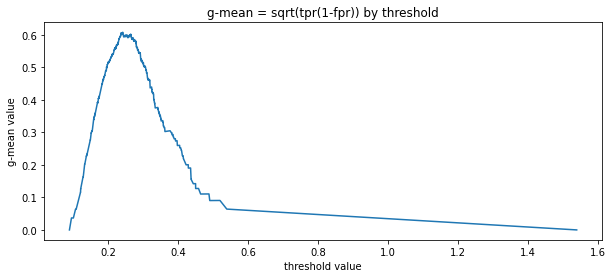

In [229]:
plt.figure(figsize=(10, 4))
plt.plot(thresholds, gmeans)
plt.xlabel("threshold value")
plt.ylabel("g-mean value")
plt.title("g-mean = sqrt(tpr(1-fpr)) by threshold")

Text(0.5, 1.0, 'performance on test data using the PCA model\nthreshold=0.2424 (G-mean maximization)')

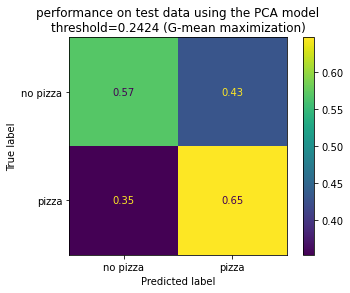

In [230]:
pred_binary = preds.copy()

threshold = thresholds[ix]
pred_binary[pred_binary >= threshold] = 1
pred_binary[pred_binary < threshold] = 0

cm = confusion_matrix(y_test, pred_binary, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no pizza", "pizza"])
disp.plot()

plt.title(
    f"performance on test data using the PCA model\nthreshold={thresholds[ix]:.4f} (G-mean maximization)"
)

In [231]:
f1 = f1_score(y_test, pred_binary)

print("F1 score", f1)
print("Classification Report")
print(classification_report(y_test, pred_binary, target_names=["pizza", "no_pizza"]))

F1 score 0.43888888888888883
Classification Report
              precision    recall  f1-score   support

       pizza       0.83      0.57      0.68       740
    no_pizza       0.33      0.65      0.44       244

    accuracy                           0.59       984
   macro avg       0.58      0.61      0.56       984
weighted avg       0.71      0.59      0.62       984



## XGBoost (Bag of words)

In [232]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [251]:
veczr = CountVectorizer(tokenizer=nltk.word_tokenize, stop_words="english")
trn_term_doc = veczr.fit(data["text"])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [252]:
X_train, X_test, y_train, y_test = train_test_split(
    veczr.transform(data["text"]),
    data["pizza"],
    test_size=0.25,
    stratify=data["pizza"],
    random_state=0,
)

In [274]:
xgb_pars = {
    "min_child_weight": 50,
    "eta": 0.005,
    "max_depth": 7,
    "subsample": 0.8,
    "silent": 1,
    "nthread": 4,
    "eval_metric": "logloss",
    "objective": "binary:logistic",
}

d_train = xgb.DMatrix(X_train, label=y_train)
d_val = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, "train"), (d_val, "valid")]

bst = xgb.train(
    xgb_pars,
    d_train,
    1000,
    watchlist,
    early_stopping_rounds=50,
    verbose_eval=50,
)

[0]	train-logloss:0.691808	valid-logloss:0.691815
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.638406	valid-logloss:0.639602
[100]	train-logloss:0.604525	valid-logloss:0.606887
[150]	train-logloss:0.582307	valid-logloss:0.585887
[200]	train-logloss:0.567644	valid-logloss:0.572391
[250]	train-logloss:0.55767	valid-logloss:0.563609
[300]	train-logloss:0.550871	valid-logloss:0.557812
[350]	train-logloss:0.546131	valid-logloss:0.554308
[400]	train-logloss:0.542614	valid-logloss:0.55188
[450]	train-logloss:0.53999	valid-logloss:0.550237
[500]	train-logloss:0.53791	valid-logloss:0.549184
[550]	train-logloss:0.536301	valid-logloss:0.548488
[600]	train-logloss:0.534894	valid-logloss:0.548168
Stopping. Best iteration:
[593]	train-logloss:0.535084	valid-logloss:0.548091



In [275]:
preds = bst.predict(d_val)

AUC score : 0.6006424457244129
best threshold 0.2695, G-Mean = 0.5585
FPR = 0.396, TPR = 0.516


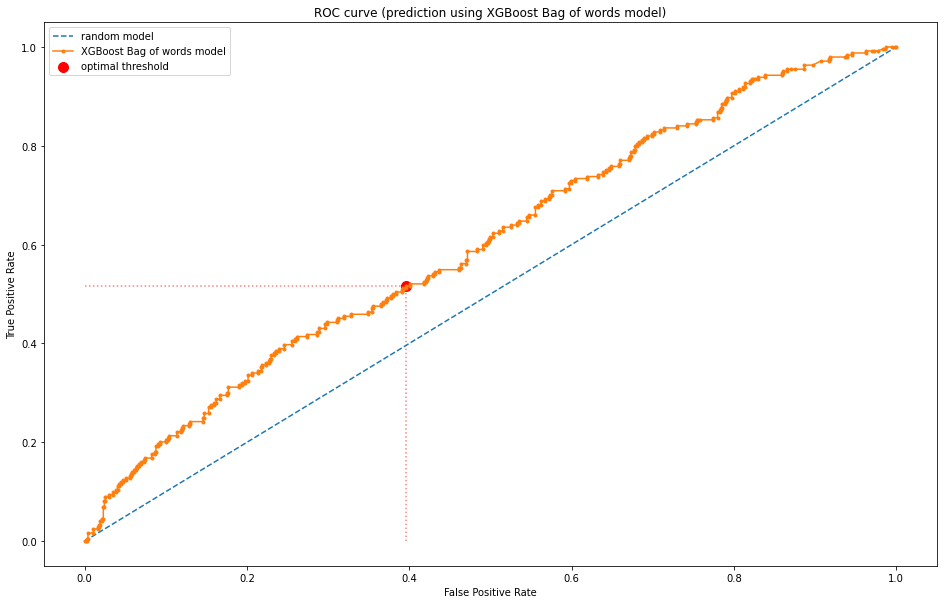

In [276]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
print(f"AUC score : {auc}")

gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)

print(f"best threshold {thresholds[ix]:.4f}, G-Mean = {gmeans[ix]:.4f}")
print(f"FPR = {fpr[ix]:.3f}, TPR = {tpr[ix]:.3f}")

plt.figure(figsize=(16, 10))
plt.plot([0, 1], [0, 1], linestyle="--", label="random model")
plt.plot(fpr, tpr, marker=".", label="XGBoost Bag of words model")
plt.title("ROC curve (prediction using XGBoost Bag of words model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.scatter(x=fpr[ix], y=tpr[ix], color="r", s=100, alpha=1, label="optimal threshold")
plt.hlines(y=tpr[ix], xmin=0, xmax=fpr[ix], color="r", linestyle=":", alpha=0.5)
plt.vlines(x=fpr[ix], ymin=0, ymax=tpr[ix], color="r", linestyle=":", alpha=0.5)
plt.legend()
plt.show()

Text(0.5, 1.0, 'g-mean = sqrt(tpr(1-fpr)) by threshold')

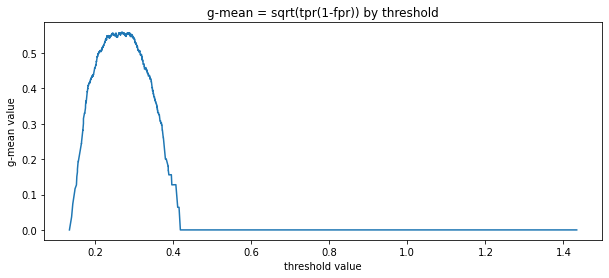

In [277]:
plt.figure(figsize=(10, 4))
plt.plot(thresholds, gmeans)
plt.xlabel("threshold value")
plt.ylabel("g-mean value")
plt.title("g-mean = sqrt(tpr(1-fpr)) by threshold")

Text(0.5, 1.0, 'performance on test data using the PCA model\nthreshold=0.2695 (G-mean maximization)')

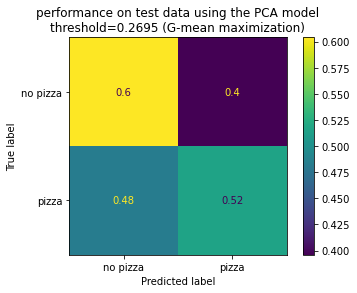

In [278]:
pred_binary = preds.copy()

threshold = thresholds[ix]
pred_binary[pred_binary >= threshold] = 1
pred_binary[pred_binary < threshold] = 0

cm = confusion_matrix(y_test, pred_binary, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no pizza", "pizza"])
disp.plot()

plt.title(
    f"performance on test data using the PCA model\nthreshold={thresholds[ix]:.4f} (G-mean maximization)"
)

In [279]:
f1 = f1_score(y_test, pred_binary)

print("F1 score", f1)
print("Classification Report")
print(classification_report(y_test, pred_binary, target_names=["pizza", "no_pizza"]))

F1 score 0.3800904977375566
Classification Report
              precision    recall  f1-score   support

       pizza       0.79      0.60      0.69       740
    no_pizza       0.30      0.52      0.38       244

    accuracy                           0.58       984
   macro avg       0.55      0.56      0.53       984
weighted avg       0.67      0.58      0.61       984



# Improvements

We could merge the different models (especially the MLP on PCA components and the BERT model) with a Neural Network. We need to remove the last Dense layers of size 1, so the NN is connected to all of the values of both our models, and can make a prediction with the text and quantitative data.

Also, we can build models around the thread titles (or we could concatenate the title and the text).